In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import gsw
from scipy.interpolate import interp1d
import xarray as xr
from datetime import datetime
from scipy.stats.distributions import chi2
from scipy import signal
from scipy.signal import fftconvolve as sci_fftconvolve
from scipy.signal import windows as windows
from scipy.optimize import curve_fit

In [4]:
transects = ['T12','T34','T56','T78']
WP_lat = [32.766478, 34.166816, 33.673312, 33.254831, 33.868988, 33.060534, 32.686389, 34.248285]
WP_lon = [-122.051875, -123.021175, -123.471025, -121.598714, -121.689333, -123.368057, -122.781231, -122.279467]
center = (33.466647, -122.536525)

In [5]:
df = pd.read_csv('../SR2006.uctd.data.csv')
tsg = pd.read_csv('../tsg.csv')
prof_uctd = xr.open_dataset('../prof_uctd.nc')
profs = xr.open_dataset("../prof_uctd_fft.nc")

# Get time columns in np datetim64 format
for column in tsg.columns:
    if 'time' in column:
        tsg[column] = tsg[column].astype(np.datetime64)
        
for column in df.columns:
    if 'time' in column:
        df[column] = df[column].astype(np.datetime64)

C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
prof_uctd['sal_good'] = prof_uctd.sal.where(~((prof_uctd.cast_time>np.datetime64('2020-08-13T02:50'))&(prof_uctd.probe==311)), other=np.nan)
prof_uctd['conductivity_good'] = prof_uctd.conductivity.where(~((prof_uctd.cast_time>np.datetime64('2020-08-13T02:50'))&(prof_uctd.probe==311)), other=np.nan)
prof_uctd['temp_good'] = prof_uctd.temp.where(~((prof_uctd.transect=='T12')&(prof_uctd.p==2)&(prof_uctd.dist_from_WP<10)), other=np.nan)

for var in ['sal','conductivity','temp']:
    prof_uctd[f'{var}_good'] = prof_uctd[f'{var}_good'].where(~((prof_uctd.transect=='T78')&(prof_uctd.p==3)&(prof_uctd.cast<3)), other=np.nan)

    
# now let's do the same thing, but apply all maskings to all variables evenly, so we can isolate the effects
# of sparse data on some variables' spectra

prof_uctd[f'temp_const'] = prof_uctd['temp'].where(~((prof_uctd.cast_time>np.datetime64('2020-08-13T02:50'))&(prof_uctd.probe==311)), other=np.nan)
prof_uctd[f'temp_const'] = prof_uctd['temp_const'].where(~((prof_uctd.transect=='T78')&(prof_uctd.p==3)&(prof_uctd.cast<3)), other=np.nan)  

In [69]:
pressure_coords = np.arange(1, 251, 1)

def prof_for_fft(transect, p, pressure=None, interp_res=[1,1], boxcar=1, block=False):
    dist_coords = np.arange(0.5, 180, interp_res[0])
    prof = prof_uctd.sel(transect=transect, p=p)
    prof = prof.sel(cast=slice(None, prof.num_casts.item()-1))
    prof = prof.assign_coords(cast=prof.dist_from_WP.values).rename({'cast':'dist'})
    prof = prof.interp(dist=dist_coords, kwargs={"bounds_error":"False"})

    for var in ['temp', 'sal', 'conductivity']:
        prof[f'{var}_good'] = prof[f'{var}_good'].interpolate_na(dim='dist', max_gap=5)
        prof[f'{var}_good'] = prof[f'{var}_good'].rolling(dist=boxcar).mean(center=True, min_periods=1)
        
    prof[f'temp_const'] = prof[f'temp_const'].interpolate_na(dim='dist', max_gap=5)
    prof[f'temp_const'] = prof[f'temp_const'].rolling(dist=boxcar).mean(center=True, min_periods=1)
        
    # Decimate back up to lower resolution 
    dist_coords = np.arange(0.5, 180, interp_res[1])
    prof = prof.interp(dist=dist_coords, kwargs={"bounds_error":"False"})
    prof['density_good'] = gsw.rho_t_exact(prof.sal_good, prof.temp_good, prof.pressure)
    prof['pot_density_good'] = gsw.pot_rho_t_exact(prof.sal_good, prof.temp_good, prof.pressure, 0)
        
    if pressure is not None:
        prof = prof.interp(pressure=pressure)
    return prof

def tsg_prof_for_fft(transect, p, interp_res = [4,4], boxcar=1, hanning=False, block=False): 
    a = tsg[(tsg.transect==transect)&(tsg.transect_pass==p)].sort_values('dist_from_WP')
    
    if block:
        tsg_dist_coords = np.arange(interp_res[1]/2, 180000, interp_res[1]) / 1000 # convert back to km
        prof = xr.Dataset(coords=dict(dist=(['dist'], tsg_dist_coords)))
        for var in ['temp', 'sal', 'conductivity']:
            prof[f'{var}_good'] = block_avg(a[var], a.dist_from_WP, tsg_dist_coords, interp_res[1]/1000, fac=0.5)
        
    else:
        prof = xr.Dataset(data_vars=dict(sal_good=(['dist'], a.sal), temp_good=(['dist'], a.temp),
                                    conductivity_good=(['dist'], a.conductivity)),
                      coords=dict(dist=(['dist'], a.dist_from_WP.values)))
        tsg_dist_coords = np.arange(interp_res[0]/2, 180000, interp_res[0]) / 1000 # convert back to km
        prof = prof.interp(dist=tsg_dist_coords, kwargs={"bounds_error":"False"})
        if hanning:
            prof = prof.rolling(dist=boxcar).construct(window_dim='window')
            for var in ['temp', 'sal', 'conductivity']:
                prof[f'{var}_good'] = (prof[f'{var}_good']*np.hanning(boxcar)/np.hanning(boxcar).sum()).sum('window').squeeze()
        else:
            prof = prof.rolling(dist=boxcar).mean(center=True, min_periods=1)
        tsg_dist_coords = np.arange(2, 180000, interp_res[1]) / 1000
        prof = prof.interp(dist=tsg_dist_coords, kwargs={"bounds_error":"False"})
    if transect=='T78' and p>2:
        prof = prof.where(prof.dist<140, other=np.nan)
        
    prof['density_good'] = gsw.rho_t_exact(prof.sal_good, prof.temp_good, 3.6)
    prof['pot_density_good'] = gsw.pot_rho_t_exact(prof.sal_good, prof.temp_good, 3.6, 0)
    
    return prof

In [70]:
def calc_turner(data, pressure, boxcar=1):
    sal_roll = data.sal_good.rolling(dist=boxcar).mean()
    temp_roll = data.temp_good.rolling(dist=boxcar).mean()
    alpha = gsw.alpha_wrt_t_exact(sal_roll, temp_roll, p=pressure).values
    beta = gsw.beta_const_t_exact(sal_roll, temp_roll, p=pressure).values
    delta_t = np.zeros(len(temp_roll))
    delta_s = np.zeros(len(sal_roll))
    delta_t[1:] = np.diff(temp_roll.values)
    delta_s[1:] = np.diff(sal_roll.values)
    delta_t[0] = delta_t[1]
    delta_s[0] = delta_s[1]

    R = (alpha*delta_t)/(beta*delta_s)
    TU = np.degrees(np.arctan(R))
    
    return R, TU

## All transects and passes

(array([0.00460059, 0.00420905, 0.0047311 , 0.00809182, 0.00649303,
        0.00525316]),
 array([-8.98218253e+01, -5.98626408e+01, -2.99034563e+01,  5.57281721e-02,
         3.00149127e+01,  5.99740971e+01,  8.99332816e+01]),
 <BarContainer object of 6 artists>)

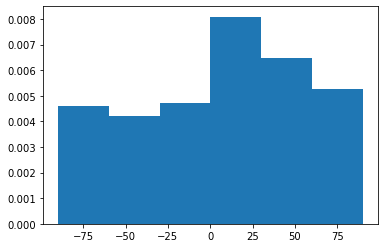

In [132]:
transects = ['T12','T12','T12','T34','T34','T34','T56','T56','T56','T78','T78','T78']
passes = [1,2,3,1,2,3,1,2,3,1,2,3]
pressure=3.6
boxcar=10

R = []
TU = []

for transect, p in zip(transects, passes):
    data = prof_for_fft(transect, p, pressure)
    r, tu = calc_turner(data, pressure, boxcar=boxcar)
    R.append(r)
    TU.append(tu)
    
R = np.concatenate(R, axis=0)
TU = np.concatenate(TU, axis=0)

plt.hist(TU, density=True, bins=6)

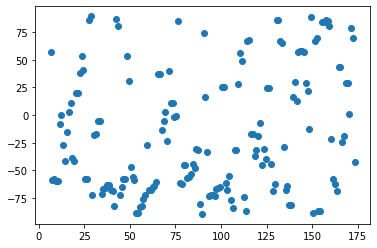

In [131]:
transects = ['T56']
passes = [1]
pressure=70
boxcar=1

R = []
TU = []

for transect, p in zip(transects, passes):
    data = prof_for_fft(transect, p, pressure)
    r, tu = calc_turner(data, pressure, boxcar=boxcar)
    R.append(r)
    TU.append(tu)
    
R = np.concatenate(R, axis=0)
TU = np.concatenate(TU, axis=0)

plt.scatter(data.dist, TU)

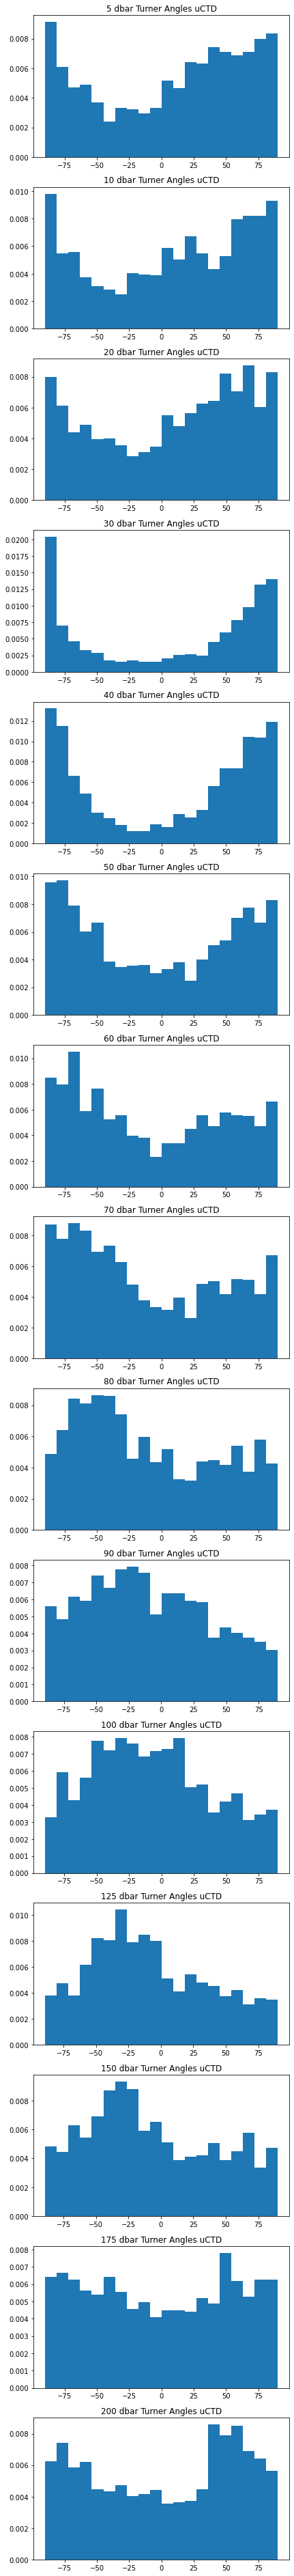

In [116]:
pressures = [5,10,20,30,40,50,60,70,80,90,100,125,150,175,200]
fig, ax = plt.subplots(len(pressures),1, figsize=(6, len(pressures)*3.5))

for i, pressure in enumerate(pressures):

    transects = ['T12','T12','T12','T34','T34','T34','T56','T56','T56','T78','T78','T78']
    passes = [1,2,3,1,2,3,1,2,3,1,2,3]
    boxcar=1

    R = []
    TU = []

    for transect, p in zip(transects, passes):
        data = prof_for_fft(transect, p, pressure)
        r, tu = calc_turner(data, pressure, boxcar=boxcar)
        R.append(r)
        TU.append(tu)

    R = np.concatenate(R, axis=0)
    TU = np.concatenate(TU, axis=0)

    ax[i].hist(TU, density=True, bins=20)
    ax[i].set_title(f'{pressure} dbar Turner Angles uCTD')

plt.tight_layout()
plt.show()

## Different Transects, all passes

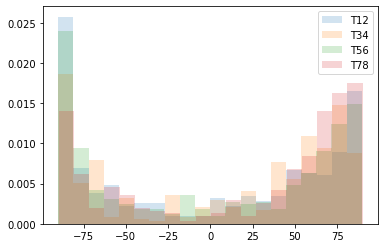

In [106]:
transects = ['T12','T34','T56','T78']
pressure=30
boxcar=1

for transect in transects:
    R = []
    TU = []
    for p in range(1,4):
        data = prof_for_fft(transect, p, pressure)
        r, tu = calc_turner(data, pressure, boxcar=boxcar)
        R.append(r)
        TU.append(tu)
    
    R = np.concatenate(R, axis=0)
    TU = np.concatenate(TU, axis=0)

    plt.hist(TU, alpha=0.2, label=transect, density=True, bins=20)
    
plt.legend()
    


## Different passes, all transects

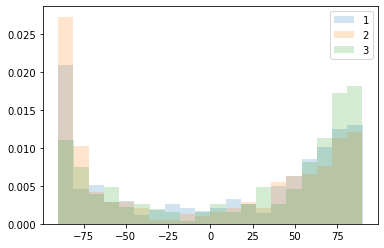

In [107]:
transects = ['T12','T34','T56','T78']
pressure=30
boxcar=1

for p in range(1,4):
    R = []
    TU = []
    for transect in transects:
        data = prof_for_fft(transect, p, pressure)
        r, tu = calc_turner(data, pressure, boxcar=boxcar)
        R.append(r)
        TU.append(tu)
    
    R = np.concatenate(R, axis=0)
    TU = np.concatenate(TU, axis=0)

    plt.hist(TU, alpha=0.2, label=p, density=True, bins=20)
    
plt.legend()
    


# TSG

## All transects and passes

C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divi

(array([0.00579941, 0.00484486, 0.00449765, 0.00406559, 0.00334304,
        0.00297417, 0.00318071, 0.00351586, 0.00457133, 0.00467204,
        0.00542362, 0.00650745, 0.00828503, 0.00819169, 0.00787128,
        0.00737893, 0.00703663, 0.00640674, 0.00567794, 0.00686716]),
 array([-90., -81., -72., -63., -54., -45., -36., -27., -18.,  -9.,   0.,
          9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.]),
 <BarContainer object of 20 artists>)

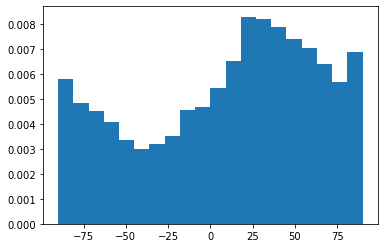

In [127]:
transects = ['T12','T12','T12','T34','T34','T34','T56','T56','T56','T78','T78','T78']
passes = [1,2,3,1,2,3,1,2,3,1,2,3]
pressure=3.6
boxcar=1000

R = []
TU = []

for transect, p in zip(transects, passes):
    data = tsg_prof_for_fft(transect, p)
    r, tu = calc_turner(data, pressure, boxcar=boxcar)
    R.append(r)
    TU.append(tu)
    
R = np.concatenate(R, axis=0)
TU = np.concatenate(TU, axis=0)

plt.hist(TU, density=True, bins=20)

## Different Transects, all passes

C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divi

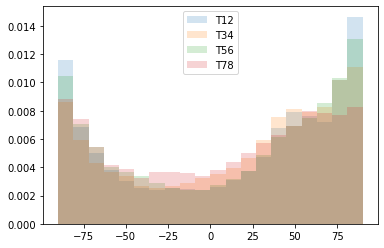

In [109]:
transects = ['T12','T34','T56','T78']
pressure=3.6
boxcar=100

for transect in transects:
    R = []
    TU = []
    for p in range(1,4):
        data = tsg_prof_for_fft(transect, p)
        r, tu = calc_turner(data, pressure, boxcar=boxcar)
        R.append(r)
        TU.append(tu)
    
    R = np.concatenate(R, axis=0)
    TU = np.concatenate(TU, axis=0)

    plt.hist(TU, alpha=0.2, label=transect, density=True, bins=20)
    
plt.legend()


## Different passes, all transects

C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divi

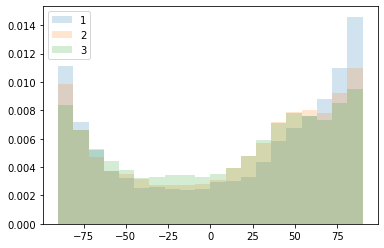

In [110]:
transects = ['T12','T34','T56','T78']
pressure=3.6
boxcar=100

for p in range(1,4):
    R = []
    TU = []
    for transect in transects:
        data = tsg_prof_for_fft(transect, p)
        r, tu = calc_turner(data, pressure, boxcar=boxcar)
        R.append(r)
        TU.append(tu)
    
    R = np.concatenate(R, axis=0)
    TU = np.concatenate(TU, axis=0)

    plt.hist(TU, alpha=0.2, label=p, density=True, bins=20)
    
plt.legend()
    
